<a href="https://colab.research.google.com/github/arjun-gangwar/Geneartive-Adversarial-Networks/blob/master/DCGAN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Utilities

In [50]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 10 10:23:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    59W / 149W |   2279MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [51]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10672993874539061616
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10197493817639222759
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11482776243948680894
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12107995543397703253
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
%matplotlib inline

## Load Dataset

In [53]:
from tensorflow.keras.datasets.cifar10 import load_data
(train_X, train_y), (test_X, test_y) = load_data()
print("Train shape: ", train_X.shape, train_y.shape)
print("Test shape: ", test_X.shape, test_y.shape)

Train shape:  (50000, 32, 32, 3) (50000, 1)
Test shape:  (10000, 32, 32, 3) (10000, 1)


## Explore Dataset

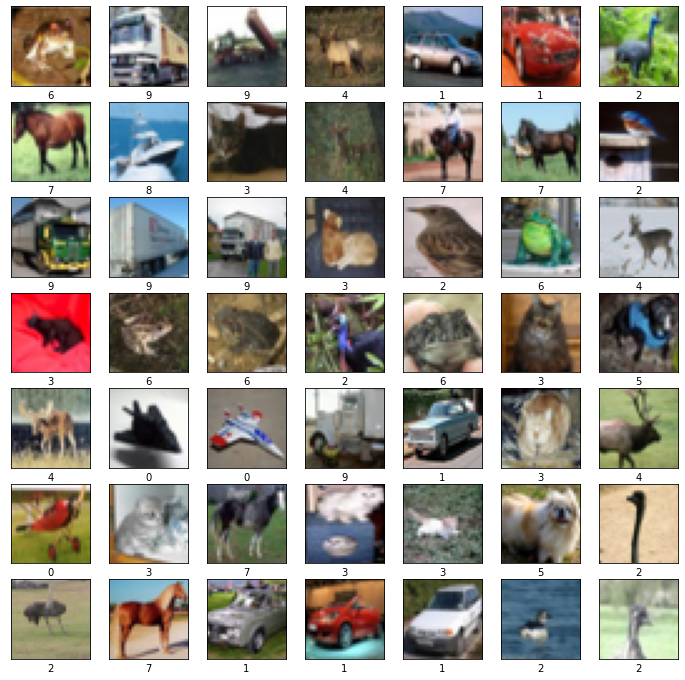

In [54]:
plt.figure(figsize=(12,12))
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.imshow(train_X[i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(train_y[i,0])

## Define Discriminator

In [0]:
def define_discriminator(in_shape=(32,32,3)):
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 4, 256)       

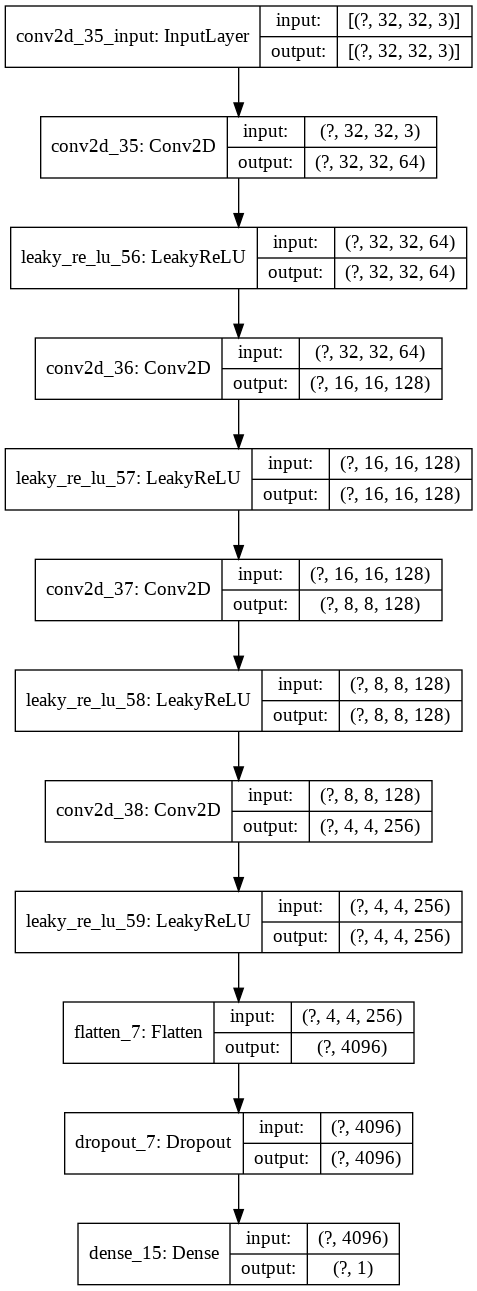

In [56]:
model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_model.png', show_layer_names=True, show_shapes=True)

## Utility Functions to load real data

In [0]:
def load_real_samples():
  (train_X, _), (_, _) = load_data()
  X = train_X.astype('float32')
  X = (X - 127.5) / 127.5
  return X

In [0]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X, y

## Define Generator

In [0]:
def define_generator(latent_dim):
  model = tf.keras.Sequential()
  n_nodes = 256 * 4 * 4
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((4,4,256)))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(3, (3,3), padding='same', activation='tanh'))
  return model

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 16, 16, 128)     

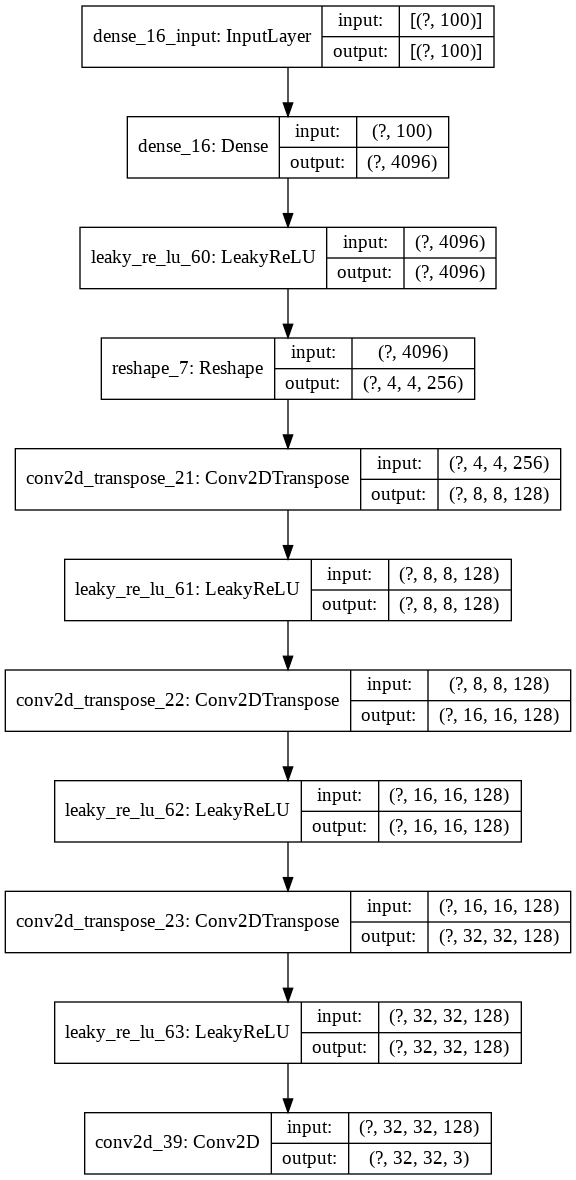

In [60]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()
plot_model(model, to_file='generator_model.png', show_layer_names=True, show_shapes=True)

## Utility Functions to load fake data

In [0]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples, 1)) 
  return X, y

## Define GAN

In [0]:
def define_gan(g_model, d_model):
  model = tf.keras.Sequential()
  d_model.trainable = False
  model.add(g_model)
  model.add(d_model)
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) 
  model.compile(loss='binary_crossentropy', optimizer=opt) 
  return model

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_23 (Sequential)   (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_22 (Sequential)   (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


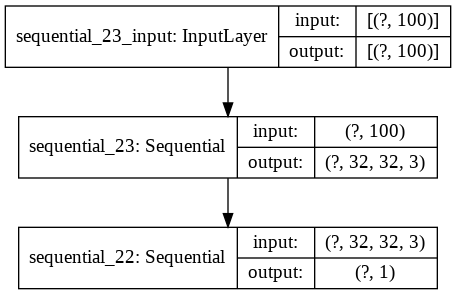

In [64]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_model.png', show_shapes=True, show_layer_names=True)

## Utility Functions to Evaluate GAN

In [0]:
def save_plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i) 
    plt.axis('off')
    plt.imshow(examples[i])
  filename = 'generated_plot_e%03d.png' % (epoch+1) 
  plt.savefig(filename)
  plt.close()

In [0]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch+1) 
  g_model.save(filename)

## Train GAN

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if (i+1) % 10 == 0:
     summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [0]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

In [0]:
import os
import imageio
img_dir = '/content/'
filenames = list()
for i in range(100):
  if((i+1) % 10 == 0):
    name = 'generated_plot_e%03d.png' % (i+1)
    name = os.path.join(img_dir, name)
    filenames.append(name)

In [0]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))

imageio.mimsave(img_dir+'movie.gif', images) 

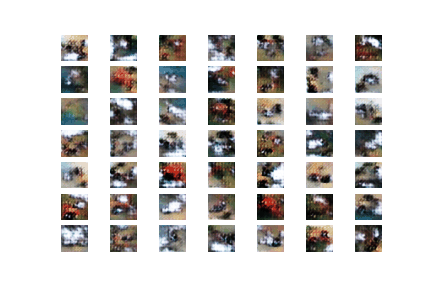

In [81]:
from IPython.display import Image
with open("/content/movie.gif",'rb') as f:
  display(Image(data=f.read(), format='png', width=1024, height=720))